In [80]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset, DataLoader
import numpy as np

version = "v1"
os.makedirs(version, exist_ok=True)
data_prep = f"{version}/data_preparation.py"
model_config = f"{version}/model_config.py"
model_train = f"{version}/model_training.py"

In [81]:
%%writefile $data_prep
device = "cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(42)

class Custom_dataset(Dataset):
    def __init__(self, features, labels):
        self.x = features
        self.y = labels

    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)

# w = torch.randn(1, device=device, requires_grad=True, dtype=torch.float)
# b = torch.randn(1, device=device, requires_grad=True, dtype=torch.float)
w = 0.5
b = 1.2

# print("real params", b, w)

# x = torch.linspace(0, 1, 100).to(device)
# this time not sending to gpu as we don't want to load the whole data in gpu memory
x = torch.linspace(0, 1, 100)
# y = (w * x + b).detach()
y = (w * x + b)

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, shuffle=True
)

train_data = Custom_dataset(x_train, y_train)
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)

Overwriting v1/data_preparation.py


In [82]:
%%writefile $model_config
device = "cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(42)
lr = 0.1

def make_train_step(model, loss_fn, optimizer):
    def perform_train_step(x, y):
        model.train()
        prediction = model(x.unsqueeze(1))
        loss = loss_fn(prediction, y.unsqueeze(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        return loss.item()

    return perform_train_step

class Linear_regression_model_class(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = torch.nn.Linear(1,1)

  def forward(self, x):
    return self.linear(x)

model = Linear_regression_model_class().to(device)
loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=lr)
train_fn = make_train_step(model, loss_fn, optimizer)

Overwriting v1/model_config.py


In [83]:
%%writefile $model_train
epochs = 100
losses = []

for epoch in range(epochs):
  mini_batch_losses = []

  for x_batch, y_batch in train_loader:
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    mini_batch_loss = train_fn(x_batch, y_batch)
    mini_batch_losses.append(mini_batch_loss)

  loss = np.mean(mini_batch_losses)
  losses.append(loss)

print(model.state_dict())

# Assuming losses is a list or 1D tensor of loss values per epoch
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

Overwriting v1/model_training.py


OrderedDict({'linear.weight': tensor([[0.5000]], device='cuda:0'), 'linear.bias': tensor([1.2000], device='cuda:0')})


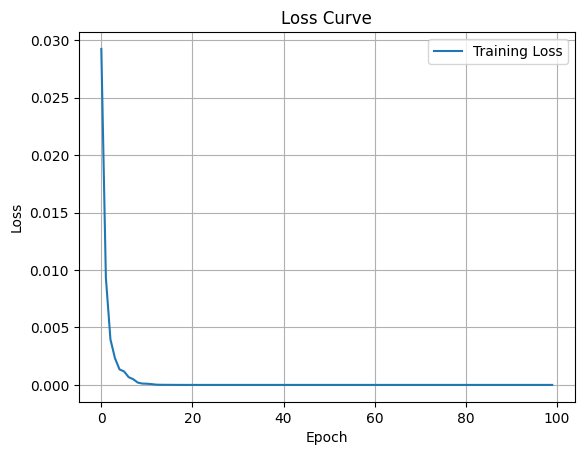

In [84]:
%run -i $data_prep
%run -i $model_config
%run -i $model_train